<a href="https://colab.research.google.com/github/vasu-rguktn/Team_X/blob/main/LSTM_Model_ASHRAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import zipfile
import os

zip_path = "/content/archive (10).zip"
extract_path = "/content/ashrae_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)


['train.feather',
 'building_metadata.feather',
 'weather_train.feather',
 'test.feather',
 'weather_test.feather',
 'sample_submission.feather']

In [25]:
!pip install pyarrow tensorflow


In [26]:
import pandas as pd

base_path = "/content/ashrae_data"

train = pd.read_feather(f"{base_path}/train.feather")
building = pd.read_feather(f"{base_path}/building_metadata.feather")
weather = pd.read_feather(f"{base_path}/weather_train.feather")


In [27]:
train.head()


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [28]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
weather['timestamp'] = pd.to_datetime(weather['timestamp'])


In [23]:
df = train.merge(building, on='building_id', how='left')
df = df.merge(weather, on=['site_id', 'timestamp'], how='left')


In [29]:
df = df[df['building_id'] < 3]   # keep 3 buildings only
df = df.sort_values('timestamp')


In [30]:
features = [
    'meter',
    'square_feet',
    'air_temperature',
    'dew_temperature',
    'wind_speed'
]

target = 'meter_reading'

X = df[features]
y = df[target]


In [31]:
df = df.sort_values('timestamp')


In [32]:
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


In [33]:
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx]
test_df  = df.iloc[split_idx:]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


In [34]:
print("Train size:", X_train.shape)
print("Test size :", X_test.shape)


Train size: (21081, 5)
Test size : (5271, 5)


In [35]:
print("DF shape:", df.shape)


DF shape: (26352, 16)


In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [37]:
import numpy as np

def create_sequences(X, y, seq_len=24):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 24

X_train_seq, y_train_seq = create_sequences(
    X_train_scaled, y_train.values, SEQ_LEN
)

X_test_seq, y_test_seq = create_sequences(
    X_test_scaled, y_test.values, SEQ_LEN
)


In [38]:
print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)
print("X_test_seq :", X_test_seq.shape)
print("y_test_seq :", y_test_seq.shape)


X_train_seq: (21057, 24, 5)
y_train_seq: (21057,)
X_test_seq : (5247, 24, 5)
y_test_seq : (5247,)


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=10,          # 5–10 is enough for mini project
    batch_size=256,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: nan - val_loss: nan
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: nan - val_loss: nan
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: nan - val_loss: nan
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: nan - val_loss: nan
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: nan - val_loss: nan
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: nan - val_loss: nan
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: nan - val_loss: nan
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: nan - val_loss: nan
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: nan - val_loss: nan
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: nan - val_loss: nan


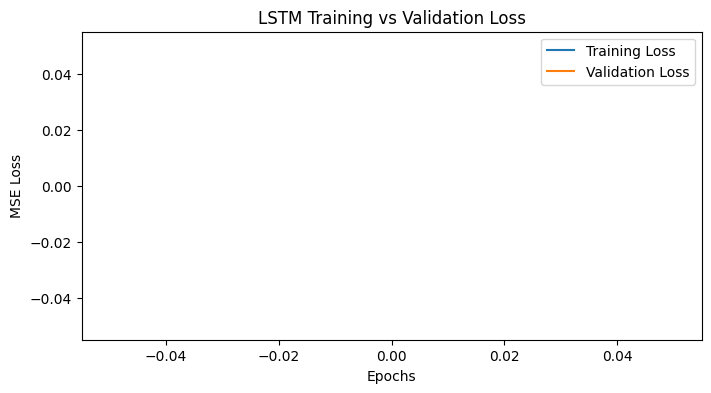

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


In [42]:
y_pred = model.predict(X_test_seq)


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae  = mean_absolute_error(y_test_seq, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))

print("MAE  :", mae)
print("RMSE :", rmse)


ValueError: Input contains NaN.

In [44]:
# Replace inf and -inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where target is NaN
df = df.dropna(subset=[target])

# Optional but recommended: log transform
df[target] = np.log1p(df[target])


In [49]:
split_date = "2016-10-01"


In [50]:
train_df = df[df['timestamp'] < split_date]
test_df  = df[df['timestamp'] >= split_date]

X_train = train_df[features]
y_train = train_df[target]

X_test  = test_df[features]
y_test  = test_df[target]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(19728, 5) (19728,)
(6624, 5) (6624,)


In [51]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(19728, 5) (19728,)
(6624, 5) (6624,)


In [52]:
print(df['timestamp'].min())
print(df['timestamp'].max())


2016-01-01 00:00:00
2016-12-31 23:00:00


In [57]:
print("NaNs in X:", X_train.isna().sum().sum())
print("NaNs in y:", y_train.isna().sum())


NaNs in X: 18
NaNs in y: 0


In [58]:
# Replace inf/-inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop ANY row with NaN in features or target
df = df.dropna(subset=features + [target])

print("After cleaning:", df.shape)


After cleaning: (26343, 16)


In [59]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna(subset=features + [target])

print("After cleaning:", df.shape)


After cleaning: (26343, 16)


In [66]:
df['meter_reading'] = np.log1p(df['meter_reading'])


In [68]:
split_date = "2016-10-01"

train_df = df[df['timestamp'] < split_date]
test_df  = df[df['timestamp'] >= split_date]

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]


In [69]:
print("NaNs in X_train:", X_train.isna().sum().sum())
print("NaNs in X_test :", X_test.isna().sum().sum())


NaNs in X_train: 0
NaNs in X_test : 0


In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("NaNs after scaling:",
      np.isnan(X_train_scaled).sum(),
      np.isnan(X_test_scaled).sum())


NaNs after scaling: 0 0


In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [72]:
SEQ_LEN = 24

X_train_seq, y_train_seq = create_sequences(
    X_train_scaled, y_train.values, SEQ_LEN
)

X_test_seq, y_test_seq = create_sequences(
    X_test_scaled, y_test.values, SEQ_LEN
)

print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)


(19695, 24, 5) (19695,)
(6600, 24, 5) (6600,)


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(SEQ_LEN, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss='mse'
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=64,
    shuffle=False
)


Epoch 1/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.0434 - val_loss: 0.5305
Epoch 2/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1031 - val_loss: 0.4130
Epoch 3/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0767 - val_loss: 0.4483
Epoch 4/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0691 - val_loss: 0.2882
Epoch 5/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0717 - val_loss: 0.2729
Epoch 6/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0716 - val_loss: 0.3254
Epoch 7/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0678 - val_loss: 0.3202
Epoch 8/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0676 - val_loss: 0.3299
Epoch 9/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0668 - val_loss: 0.3172
Epoch 10/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0675 - val_loss: 0.3597


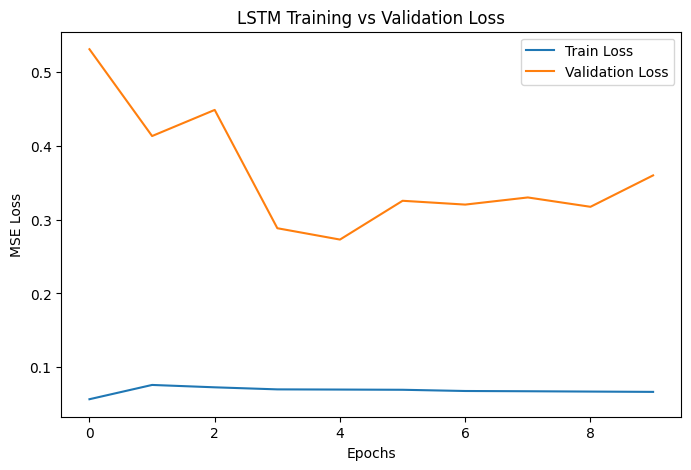

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('LSTM Training vs Validation Loss')
plt.legend()
plt.show()


In [76]:
y_pred = model.predict(X_test_seq).flatten()


207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [77]:
y_test_real = np.expm1(y_test_seq)
y_pred_real = np.expm1(y_pred)


In [78]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print("MAE :", mae)
print("RMSE:", rmse)


MAE : 1.0692144632339478
RMSE: 1.1565685864308755


In [79]:
model.save("ashrae_lstm_model.h5")


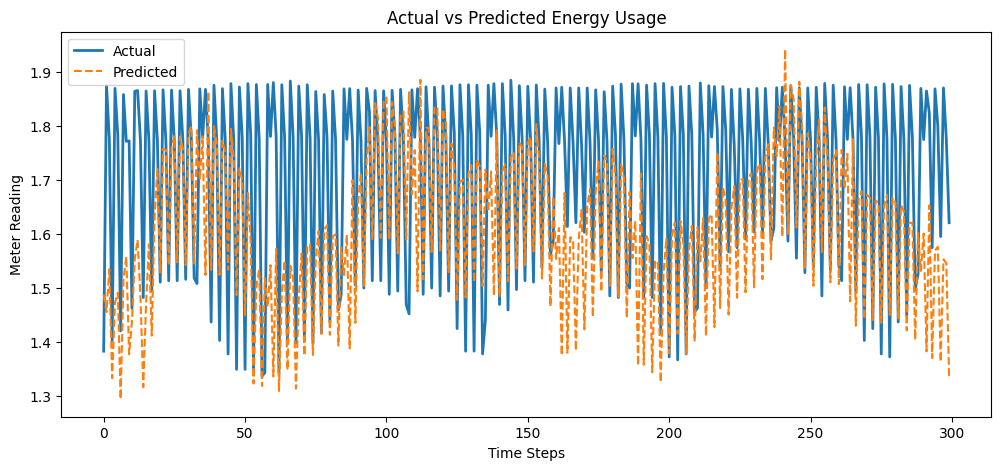

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_real[:300], label="Actual", linewidth=2)
plt.plot(y_pred_real[:300], label="Predicted", linestyle="--")
plt.title("Actual vs Predicted Energy Usage")
plt.xlabel("Time Steps")
plt.ylabel("Meter Reading")
plt.legend()
plt.show()


In [81]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_real, y_pred_real)
print("R2 Score:", r2)


R2 Score: -18.77943992614746
